## Identify the potential factors affecting the reproducibility of proteins

**Input:** 
<ul>
    <li> Aggregated protein reproducibility rank</li>
    <li> CCLE, Colon and OV reproducibility correlation</li>
    <li> Protein properties - abundance, unique peptides, half-lives.</ul>
</ul>          

#### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import common_utils
import graphing_utils as gu
import customized_plots
%matplotlib inline
plt.style.use(['seaborn-white'])

In [2]:
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'+'/'.join(folders) +'/'+ fname)

file_proteomic_replicate_ranks = get_local_data_path(['results'], 'TableS2.xlsx')
file_protein_properties = get_local_data_path(['processed'], 'protein_properties.csv')

#### Load data

In [3]:
proteomic_replicate_rank = pd.read_excel(file_proteomic_replicate_ranks, sheet_name='B. Protein reproducibility rank', 
                                         index_col=0)
proteomic_replicate_rank.rename(columns = lambda x: x.replace(' Reproducibility Rank', ''), inplace=True)
proteomic_replicate_rank[:2]

,Ovarian,Colon,CCLE,Aggregated
A1BG,0.772775,0.45424,NaN,0.575671
A2M,0.883270,0.39603,0.22406,0.501120


In [4]:
aggregated_ranks = proteomic_replicate_rank['Aggregated'].copy(deep=True).dropna()
replicates_ccle_ranks = proteomic_replicate_rank['CCLE'].copy(deep=True).dropna()
replicates_ov_ranks = proteomic_replicate_rank['Ovarian'].copy(deep=True).dropna()
replicates_colon_ranks = proteomic_replicate_rank['Colon'].copy(deep=True).dropna()

In [5]:
protein_properties = pd.read_csv(file_protein_properties, index_col=0)
protein_properties[:2]

,GTEx_Mean_Abundance,GTEx_Abundance_Variance,GTEx_Unique_Peptides,Protein sequence length,Molecular weight [kDa],T1/2 [h]
A1BG,1357.680477,2.402719e+06,22.0,NaN,NaN,NaN
A2M,10540.179562,1.272133e+08,77.0,NaN,NaN,NaN


In [6]:
protein_abundance = protein_properties['GTEx_Mean_Abundance'].copy(deep=True).dropna()
protein_unique_peptides = protein_properties['GTEx_Unique_Peptides'].copy(deep=True).dropna()
protein_variance = protein_properties['GTEx_Abundance_Variance'].copy(deep=True).dropna()
protein_half_lives = protein_properties['T1/2 [h]'].copy(deep=True).dropna()

In [7]:
print("Protien half-life Range: ", protein_half_lives.min(), " - ", protein_half_lives.max())
print("Protien mean abundance Range: ", protein_abundance.min(), " - ", protein_abundance.max())
print("Protien unique peptides Range: ", protein_unique_peptides.min(), " - ", protein_unique_peptides.max())
print("Thus, log-transformation is applied to all the above factors!")
protein_abundance = np.log10(protein_abundance + 1)
protein_variance = np.log10(protein_variance + 1)
protein_unique_peptides = np.log10(protein_unique_peptides + 1)
protein_half_lives = np.log10(protein_half_lives + 1)

Protien half-life Range:  0.2331348885205769  -  inf
Protien mean abundance Range:  76.17350896130952  -  387741.52997729526
Protien unique peptides Range:  1.0  -  2558.0
Thus, log-transformation is applied to all the above factors!


In [8]:
#converting half-lives to binary - 'Long' and 'Short' 
protein_half_lives_binary = pd.Series(['Long' if val > protein_half_lives.median() \
                                       else 'Short' for val in protein_half_lives], index=protein_half_lives.index)

**Performing Mann-Whitney test to ensure the Aggregated Protein Reproduciility Rank are protein half-lives 'Long' and 'short' are from different distribution**

In [9]:
protein_half_lives_ranks = pd.concat([protein_half_lives_binary, aggregated_ranks, replicates_ccle_ranks, 
                                      replicates_colon_ranks, replicates_ov_ranks], axis=1)
protein_half_lives_ranks.columns= ['half-life', 'AggregatedRank', 'CCLE', 'Colon', 'OV']
protein_half_lives_ranks[:2]

,half-life,AggregatedRank,CCLE,Colon,OV
AACS,Long,0.629721,0.837034,NaN,0.552130
AAK1,Long,0.412224,0.532869,0.366083,0.337721


In [10]:
import scipy.stats as stats
print('Mann-Whitney U statistic p-value for Long vs. Short Protein half-lives: p-val = ', 
     stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['AggregatedRank'].dropna(), 
                       protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['AggregatedRank'].dropna(), 
                       alternative='two-sided')[1])

Mann-Whitney U statistic p-value for Long vs. Short Protein half-lives: p-val =  1.439746334973342e-24


#### Regress to understand the amount of variation in aggregated ranks explained by each of the factor

In [11]:
import statsmodels.api as sm
def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = common_utils.get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset)).fit()
    return est

In [12]:
combined_factors = pd.concat([protein_abundance, protein_variance, pd.get_dummies(protein_half_lives_binary), 
                                    protein_unique_peptides], axis=1, join='inner')
print('Dimensions: ', combined_factors.shape)
combined_factors[:2]

Dimensions:  (3713, 5)


,GTEx_Mean_Abundance,GTEx_Abundance_Variance,Long,Short,GTEx_Unique_Peptides
AACS,2.494105,5.416879,1,0,1.230449
AAK1,2.954609,6.005358,1,0,1.431364


In [13]:
rsquared_abundance = {} ; rsquared_peptides = {} ; rsquared_halflives = {} ; rsquared_all_factors = {} ;rsquared_variance = {};

rsquared_abundance[aggregated_ranks.name] = round(ols_fit(x=protein_abundance, y=aggregated_ranks).rsquared_adj*100, 2)
rsquared_peptides[aggregated_ranks.name] = round(ols_fit(x=protein_unique_peptides, y=aggregated_ranks).rsquared_adj*100, 
                                                 2)
# Since categorical variables are not directly used in OLS, generate dummies variables for regression
rsquared_halflives[aggregated_ranks.name] = round(ols_fit(x=pd.get_dummies(protein_half_lives_binary), 
                                                          y=aggregated_ranks).rsquared_adj*100, 2)
rsquared_variance[aggregated_ranks.name] = round(ols_fit(x=protein_variance, 
                                                         y=aggregated_ranks).rsquared_adj*100, 2)
rsquared_all_factors[aggregated_ranks.name] = round(ols_fit(y=aggregated_ranks, 
                                                            x=combined_factors).rsquared_adj * 100, 2)

In [14]:
ylab = 'Aggregated Protein \nReproducibility Ranks'
palette = [gu.get_color('light-orange')]
args = [gu.additional_plot_parameters(ylab=ylab,palette=palette, r2=rsquared_abundance[aggregated_ranks.name],
                                      xlab="GTEX 32 healthy tissues mean abundance\n(log transformed) deciles"),
        gu.additional_plot_parameters(ylab=ylab, palette=palette, r2=rsquared_peptides[aggregated_ranks.name],
                                      xlab="GTEx unique peptides count (log transformed) deciles"), 
        gu.additional_plot_parameters(ylab=ylab, palette=palette, 
                                      xlab="GTEX 32 healthy tissues variance\n(log transformed) deciles", 
                                      r2=rsquared_variance[aggregated_ranks.name]),
        gu.additional_plot_parameters(ylab=ylab, palette=palette, xlab="Protein half-lives", 
                                      r2=rsquared_halflives[aggregated_ranks.name])]

In [15]:
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
def draw_boxplot(ax, x, y, args):
    x_subset, y_subset = common_utils.get_matched_index(x, y)
    dataframe = pd.DataFrame('', index=x_subset.index, columns=[y.name, 'Protein half-life'])
    dataframe[y.name] = y_subset
    global_median = dataframe[y.name].median()
    dataframe['Protein half-life'] = x_subset

    ax.hlines(global_median, colors='#999999', linestyle=':', linewidth=2, xmin=-1, xmax =10, zorder=10)
    sns.boxplot(y=y.name, ax=ax, x='Protein half-life', data=dataframe, 
                order=["Short", "Long"], showfliers=False, 
                medianprops={'color':'black', 'linewidth':1.25, 'linestyle': '-'},
                whiskerprops={'color': args.palette[0], 'linewidth':1.5, 'linestyle': '--'}, 
                capprops={'linewidth': 0}, boxprops={'facecolor': args.palette[0], 'linewidth': 0})
    medians = dataframe.groupby(['Protein half-life'])[y.name].median().round(2).sort_values()
    count = len(dataframe)
    
    for xtick in ax.get_xticks():  
        if(medians.iloc[xtick] > global_median):
            ax.text(xtick+0.1, medians.iloc[xtick] + 0.025, medians.iloc[xtick], horizontalalignment='center',
                    size='9', color='black')
        else:
            ax.text(xtick+0.1, medians.iloc[xtick] - 0.075, medians.iloc[xtick], horizontalalignment='center',
                    size='9', color='black')
    ax.text(ax.get_xticks()[-1]+0.85, (ax.get_yticks()[-1] - 0.1) , 
            'N = '+ str(count), horizontalalignment='center',size='10',
            color='black')
    ax.set_xlim(right=2)
    if(args.r2!=None):
        at = AnchoredText("$\mathregular{R^2}$ = "+ str(round(args.r2, 2))+"%", loc="lower right", frameon=True,
                               prop=dict(fontsize='10', color='black'))
        at.patch.set_edgecolor('white')
        at.patch.set_facecolor('white')
        at.patch.set_alpha(1)  
        ax.add_artist(at)
    
    customized_plots.customise_plot(ax, args)

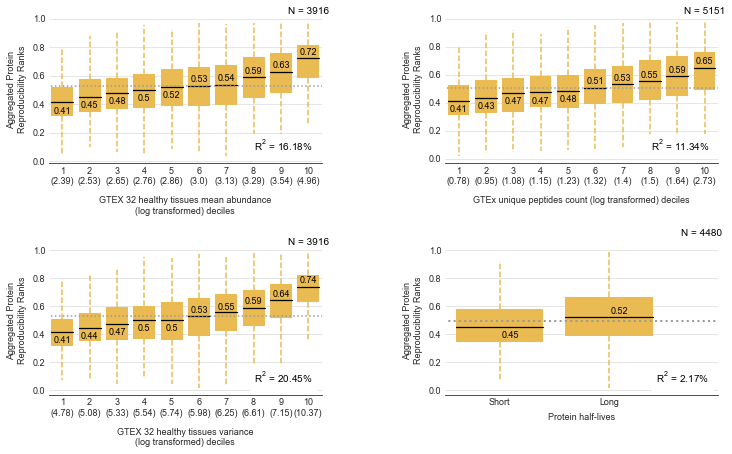

In [16]:
with plt.rc_context({'axes.linewidth': 0.8}):
    figure, ax = plt.subplots(2, 2, figsize=(12, 7))
    customized_plots.draw_boxplot(ax[0, 1], protein_unique_peptides, aggregated_ranks, args[1])
    customized_plots.draw_boxplot(ax[0, 0], protein_abundance, aggregated_ranks, args[0])
    draw_boxplot(ax[1, 1], protein_half_lives_binary, aggregated_ranks, args[3])
    customized_plots.draw_boxplot(ax[1, 0], protein_variance, aggregated_ranks, args[2])
    plt.subplots_adjust(hspace=0.55, wspace=0.45)
#     figure.savefig('../figures/Figure5.svg', bbox_inches='tight', dpi=300)

#### Validate the findings using the potential feature against individual study's protein reproducibility rank

In [17]:
print('Ovarian Cancer: \nMann-Whitney U statistic for Long vs. Short Protein half-lives: p-val = ', 
      stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['OV'].dropna(), 
                         protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['OV'].dropna(), 
                         alternative='two-sided')[1])

print('Colon Cancer: \nMann-Whitney U statistic for Long vs. Short Protein half-lives: p-val = ', 
      stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['Colon'].dropna(), 
                         protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['Colon'].dropna(), 
                         alternative='two-sided')[1])

print('CCLE Cancer: \nMann-Whitney U statistic for Long vs. Short Protein half-lives: p-val = ', 
      stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['CCLE'].dropna(), 
                         protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['CCLE'].dropna(), 
                         alternative='two-sided')[1])

Ovarian Cancer: 
Mann-Whitney U statistic for Long vs. Short Protein half-lives: p-val =  1.2705017347146962e-41
Colon Cancer: 
Mann-Whitney U statistic for Long vs. Short Protein half-lives: p-val =  0.04724911115331449
CCLE Cancer: 
Mann-Whitney U statistic for Long vs. Short Protein half-lives: p-val =  4.9321539234919467e-17


In [18]:
all_replicate_ranks = [replicates_colon_ranks, replicates_ov_ranks, replicates_ccle_ranks, aggregated_ranks]

for study in all_replicate_ranks:
    rsquared_abundance[study.name] = round(ols_fit(x=protein_abundance, y=study).rsquared_adj*100, 2)
    rsquared_peptides[study.name] = round(ols_fit(x=protein_unique_peptides, y=study).rsquared_adj*100, 2)
    rsquared_variance[study.name] = round(ols_fit(x=protein_variance, y=study).rsquared_adj*100, 2)
    rsquared_halflives[study.name] = round(ols_fit(x=pd.get_dummies(protein_half_lives_binary), 
                                                   y=study).rsquared_adj*100, 2)

In [19]:
ylab = "Protein Reproducibility Ranks"
xlab1 = 'GTEX 32 healthy tissues mean abundance\n(log transformed) deciles'
xlab3 = 'GTEx unique peptides count (log transformed) deciles'
xlab2 = 'GTEx 32 healthy tissues protein variance\n(log transformed) deciles'
xlab4 = 'Protein half-lives'

args = [gu.additional_plot_parameters(ylab=ylab, xlab=xlab1, palette=palette, r2=rsquared_abundance[replicates_colon_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab1, palette=palette, r2=rsquared_abundance[replicates_ov_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab1, palette=palette, r2=rsquared_abundance[replicates_ccle_ranks.name]),
        gu.additional_plot_parameters(ylab=ylab, xlab=xlab2, palette=palette, r2=rsquared_variance[replicates_colon_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab2, palette=palette, r2=rsquared_variance[replicates_ov_ranks.name]), 
        gu.additional_plot_parameters(xlab=xlab2, palette=palette, r2=rsquared_variance[replicates_ccle_ranks.name]),
        gu.additional_plot_parameters(ylab=ylab, xlab=xlab3, palette=palette, r2=rsquared_peptides[replicates_colon_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab3, palette=palette, r2=rsquared_peptides[replicates_ov_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab3, palette=palette, r2=rsquared_peptides[replicates_ccle_ranks.name]),   
        gu.additional_plot_parameters(ylab=ylab, xlab=xlab4, palette=palette, r2=rsquared_halflives[replicates_colon_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab4, palette=palette, r2=rsquared_halflives[replicates_ov_ranks.name]), 
        gu.additional_plot_parameters(xlab=xlab4, palette=palette, r2=rsquared_halflives[replicates_ccle_ranks.name]),
        gu.additional_plot_parameters(xlab='R-squared (%)', ylab=None, yaxis_grid=False, xaxis_grid=True, 
                                      palette = [gu.get_color(name) for name in ['orange', 'sky-blue', 
                                                                                 'green', 'reddish-purple', 'grey']],
                                      anchor_legend_at=(1.1, 1))]

In [20]:
for study in all_replicate_ranks:
    rsquared_abundance[study.name] = round(ols_fit(x=combined_factors['GTEx_Mean_Abundance'], y=study).rsquared_adj*100, 2)
    rsquared_peptides[study.name] = round(ols_fit(x=combined_factors['GTEx_Unique_Peptides'], y=study).rsquared_adj*100, 2)
    rsquared_halflives[study.name] = round(ols_fit(x=combined_factors[['Long', 'Short']], 
                                                   y=study).rsquared_adj*100, 2)
    rsquared_variance[study.name] = round(ols_fit(x=combined_factors['GTEx_Abundance_Variance'], y=study).rsquared_adj*100, 2)
    rsquared_all_factors[study.name] = round(ols_fit(y=study, x=combined_factors).rsquared_adj * 100, 2)

In [21]:
proteins_count = {study.name: len(study[study.index.isin(combined_factors.index)]) for study in all_replicate_ranks}
rsquared_factors = common_utils.dataframe_from_dict(['Protein half-lives', '# Unique Peptides', 'Protein Variance',
                                                     'Protein Abundance', 'All', 'Proteins Count'], 
                                                rsquared_halflives,   rsquared_peptides, rsquared_variance,
                                                rsquared_abundance, rsquared_all_factors, proteins_count,
                                                repeat_factor=len(rsquared_abundance))

Factor,Data,# Unique Peptides,All,Protein Abundance,Protein Variance,Protein half-lives,Proteins Count
0,Aggregated,8.74,21.44,15.65,19.72,0.95,3441
1,CCLE,1.56,7.33,2.42,4.63,0.16,3578
2,Colon,12.38,17.72,8.05,10.51,-0.01,2306
3,Ovarian,5.07,22.59,21.13,21.44,2.11,3478


#### Checking the influence of mRNA abundance and variance on transcriptomic reproducibility

In [22]:
file_mRNA_protein_correlation = get_local_data_path(['results'], 'TableS1.xlsx')
file_transcriptomic_reproducibility_cor = get_local_data_path(['processed', 'correlation_replicates'], 
                                                              'transcriptomic_reproducibility.xlsx')

In [23]:
mRNA_protein_correlation = pd.read_excel(file_mRNA_protein_correlation, sheet_name='A. mRNA-protein correlation', 
                                         index_col=0)
mRNA_protein_correlation[:2]

,CRC (2014),BrCa (2016),Ovarian,Colon,ccRCC,EC,LUAD,BrCa (2020),HNSCC,GBM,NCI60,CCLE,GTEx
Gene symbol,,,,,,,,,,,,,
A1BG,0.123133,-0.093805,-0.078889,NaN,0.035573,0.324974,-0.119663,0.077242,0.065872,-0.192863,NaN,NaN,0.154523
A1CF,NaN,NaN,NaN,0.673548,0.908613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188605


In [24]:
correlation_transcriptomics = pd.read_excel(file_transcriptomic_reproducibility_cor, sheet_name='Reproducibility', 
                                            usecols=['Unnamed: 0', 'CCLE-Klijn'], index_col=0, squeeze=True).dropna()
print("Dimensions: ", correlation_transcriptomics.shape)
# Limiting the analysis to only those proteins containing mRNA-protein correlation at least in one study. 
correlation_transcriptomics = correlation_transcriptomics.reindex(correlation_transcriptomics.index[correlation_transcriptomics.index.isin(mRNA_protein_correlation.index)])
print("Dimensions revised: ", correlation_transcriptomics.shape)
correlation_transcriptomics[:2]

Dimensions:  (13226,)
Dimensions revised:  (10036,)


A1BG    0.758553
AAAS    0.723896
Name: CCLE-Klijn, dtype: float64

In [25]:
mRNA_abundance_variance = pd.read_csv(get_local_data_path(['processed'], 'mRNA_abundance_variance.csv'), index_col=0)
mRNA_abundance_variance[:2]

,CCLE mean abundance,CCLE abundance variance
A1BG,2.975573,4.158764
A1CF,0.274645,0.732632


In [26]:
rsquared_transcriptomic_abundance = {}
rsquared_transcriptomic_variance = {}
print("Regressing mRNA-protein correlation using protein or transcriptomic reproducibility factors")
rsquared_transcriptomic_abundance['Transcriptomic Reproducibility'] = round(ols_fit(x=mRNA_abundance_variance['CCLE mean abundance'], 
                                                        y=correlation_transcriptomics).rsquared_adj*100, 2)
rsquared_transcriptomic_variance['Transcriptomic Reproducibility'] = round(ols_fit(x=mRNA_abundance_variance['CCLE abundance variance'], 
                                                        y=correlation_transcriptomics).rsquared_adj*100, 2)

Regressing mRNA-protein correlation using protein or transcriptomic reproducibility factors


In [27]:
proteins_count = {'Transcriptomic Reproducibility': len(np.intersect1d(correlation_transcriptomics.index,
                                                                       mRNA_abundance_variance.index))}
rsquared_transcriptomic = common_utils.dataframe_from_dict(['mRNA\nvariance', 'mRNA\nabundance', 'Proteins Count'], 
                                                 rsquared_transcriptomic_variance, rsquared_transcriptomic_abundance, 
                                                 proteins_count, repeat_factor=len(rsquared_transcriptomic_abundance))

Factor,Data,mRNA abundance,mRNA variance,Proteins Count
0,Transcriptomic Reproducibility,4.42,28.33,10036


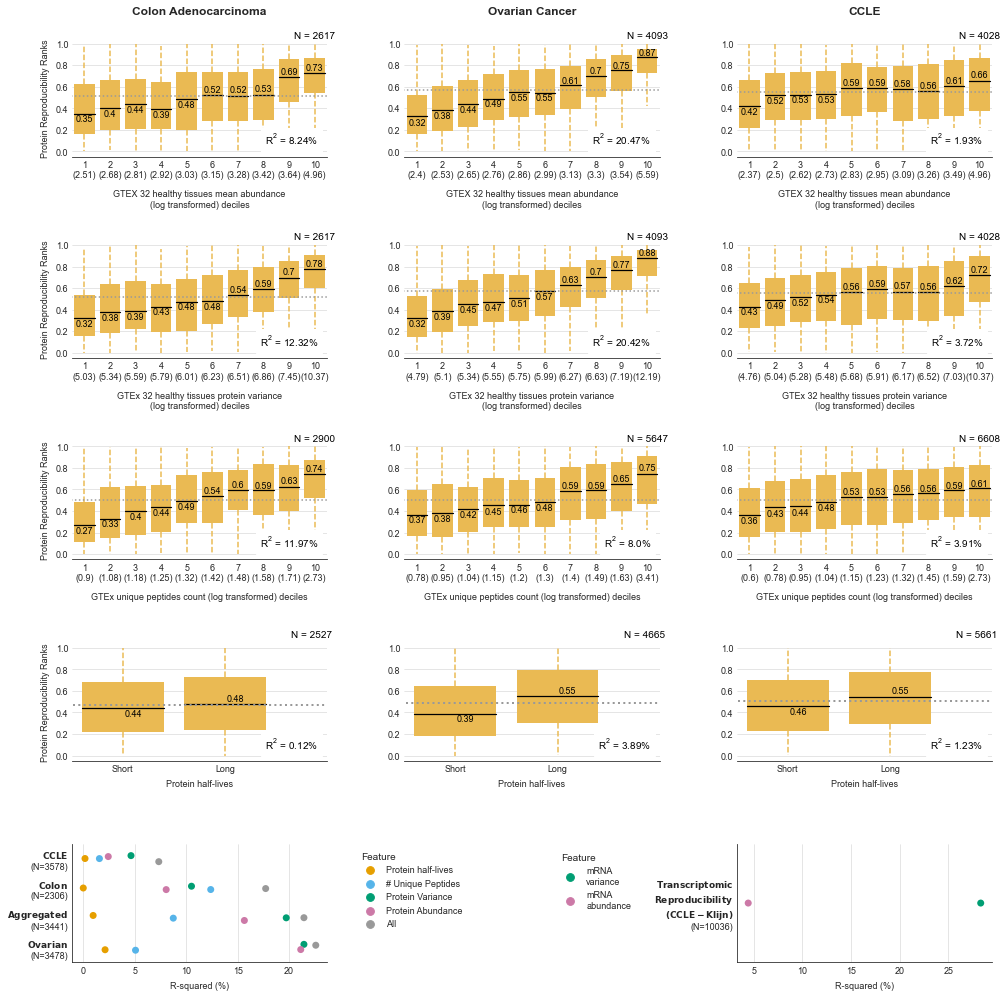

In [28]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
with plt.rc_context({'axes.linewidth': 0.8}):
    figure, ax = plt.subplots(5, 3, figsize=(16.5,17))
    customized_plots.draw_boxplot(ax[0, 0], protein_abundance, replicates_colon_ranks, args[0])
    customized_plots.draw_boxplot(ax[0, 1], protein_abundance, replicates_ov_ranks, args[1])
    customized_plots.draw_boxplot(ax[0, 2], protein_abundance, replicates_ccle_ranks, args[2])
    customized_plots.draw_boxplot(ax[1, 0], protein_variance, replicates_colon_ranks, args[3])
    customized_plots.draw_boxplot(ax[1, 1], protein_variance, replicates_ov_ranks, args[4])    
    customized_plots.draw_boxplot(ax[1, 2], protein_variance, replicates_ccle_ranks, args[5])
    customized_plots.draw_boxplot(ax[2, 0], protein_unique_peptides, replicates_colon_ranks, args[6])
    customized_plots.draw_boxplot(ax[2, 1], protein_unique_peptides, replicates_ov_ranks, args[7])    
    customized_plots.draw_boxplot(ax[2, 2], protein_unique_peptides, replicates_ccle_ranks, args[8])
    draw_boxplot(ax[3, 0], protein_half_lives_binary, replicates_colon_ranks, args[9])
    draw_boxplot(ax[3, 1], protein_half_lives_binary, replicates_ov_ranks, args[10])
    draw_boxplot(ax[3, 2], protein_half_lives_binary, replicates_ccle_ranks, args[11])
    ax[0,0].set_title("Colon Adenocarcinoma", weight='bold', y=1.15, size=12, loc='center')
    ax[0,1].set_title("Ovarian Cancer", weight='bold', y=1.15, size=12, loc='center')
    ax[0,2].set_title("CCLE", weight='bold', y=1.15, size=12, loc='center')
    customized_plots.draw_dotplot(ax=ax[4, 0], x='R-squared', y='Data', data=rsquared_factors, hue='Factor', 
                                  order=get_order(rsquared_factors), args=args[12], jitter=0.15)
    customized_plots.draw_dotplot(ax=ax[4,2], x='R-squared', y='Data', data=rsquared_transcriptomic, hue='Factor',  
                                  order=get_order(rsquared_transcriptomic),
                                  args=gu.additional_plot_parameters(xlab="R-squared (%)", ylab=None, 
                                                                     yaxis_grid=False, xaxis_grid=True,  
                                                                     palette=[gu.get_color('green'), 
                                                                              gu.get_color('reddish-purple')],
                                                                     anchor_legend_at=(-0.38, 0.99)))
    ax[4,0].spines['left'].set_visible(True); ax[4,2].spines['left'].set_visible(True)
    ax[4, 1].axis('off'); 
    plt.subplots_adjust(wspace=0.3, hspace=0.7)
#     figure.savefig('../figures/S5.svg', bbox_inches='tight', dpi=300)

In [29]:
from scipy import stats
chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [30]:
def lrtest(llmin, llmax, df=3):
    lr = 2 * (llmax - llmin)
    p = chisqprob(lr, df) # llmax has 3 dof more than llmin as protein half-lives as has dummy variables - Long and Short
    return lr, p

In [31]:
for study in all_replicate_ranks: 
    print(study.name)
    llf_abundance = ols_fit(x=combined_factors['GTEx_Mean_Abundance'], y = study).llf
    llf_peptides = ols_fit(x=combined_factors['GTEx_Unique_Peptides'], y = study).llf
    llf_halflives = ols_fit(x=combined_factors[['Long', 'Short']], y=study).llf
    llf_variance= ols_fit(x=combined_factors['GTEx_Abundance_Variance'], y=study).llf
    llf_combined = ols_fit(x=combined_factors, y=study).llf    
    
    lr, p = lrtest(llf_abundance, llf_combined)
    print('Abundance v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
    lr, p = lrtest(llf_variance, llf_combined)
    print('Variance v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
    lr, p = lrtest(llf_peptides, llf_combined)
    print('Unique Peptides v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
    # Change degrees of freedom to 2 as protein-half-lives is represented as 2 features
    lr, p = lrtest(llf_halflives, llf_combined, df = 2) 
    print('Protein half-lives v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}\n'.format(lr, p))

Colon
Abundance v/s combined model: LR test statistic = 259.16,  p value = 6.8358e-56
Variance v/s combined model: LR test statistic = 196.69,  p value = 2.1846e-42
Unique Peptides v/s combined model: LR test statistic = 147.93,  p value = 7.3655e-32
Protein half-lives v/s combined model: LR test statistic = 452.93,  p value = 4.4436e-99

Ovarian
Abundance v/s combined model: LR test statistic = 67.69,  p value = 1.331e-14
Variance v/s combined model: LR test statistic = 54.39,  p value = 9.2591e-12
Unique Peptides v/s combined model: LR test statistic = 712.45,  p value = 4.1988e-154
Protein half-lives v/s combined model: LR test statistic = 819.29,  p value = 1.2384e-178

CCLE
Abundance v/s combined model: LR test statistic = 187.81,  p value = 1.8151e-40
Variance v/s combined model: LR test statistic = 105.59,  p value = 9.7371e-23
Unique Peptides v/s combined model: LR test statistic = 219.14,  p value = 3.0828e-47
Protein half-lives v/s combined model: LR test statistic = 269.62, 

<div class="alert alert-block alert-success">
    Based on the above results where p < 0.001 in most cases (except CCLE Abundance v/s combined model), we understand that the combined model is better than the individual model for all the studies considered. However, cases where the LR test statistic is not very large (depending on the predictability of the factors - for e.g., aggreated rank abundance v/s combined model), we can say that  the individual factor model is almost as good as the combined model despite a p < 0.001 </div>